In [42]:
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u

plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

In [3]:
#reading in the table
primer_phot_tab = Table.read('primercosmos_photom_v0.2.fits.gz')

In [4]:
primer_phot_tab.columns

<TableColumns names=('ID','COORDID','RA','DEC','X','Y','KRON_RADIUS','A_IMAGE','B_IMAGE','THETA_IMAGE','APCORR','APCORR_APER','APCORR_WINGS','STELLARITY','ISOAREA_IMAGE','D_APER','FLUX_F435W','FLUXERR_F435W','FLUX_APER_F435W','FLUX_APER_NATIVE_F435W','FLUXERR_APER_F435W','FLUX_APERTOT_F435W','FLUXERR_APERTOT_F435W','RH_F435W','FWHM_F435W','FLUXERR_LOCAL_D0P2_F435W','FLUXERR_LOCAL_D0P3_F435W','FLUXERR_LOCAL_D0P4_F435W','FLUXERR_LOCAL_D0P5_F435W','FLUX_F606W','FLUXERR_F606W','FLUX_APER_F606W','FLUX_APER_NATIVE_F606W','FLUXERR_APER_F606W','FLUX_APERTOT_F606W','FLUXERR_APERTOT_F606W','RH_F606W','FWHM_F606W','FLUXERR_LOCAL_D0P2_F606W','FLUXERR_LOCAL_D0P3_F606W','FLUXERR_LOCAL_D0P4_F606W','FLUXERR_LOCAL_D0P5_F606W','FLUX_F814W','FLUXERR_F814W','FLUX_APER_F814W','FLUX_APER_NATIVE_F814W','FLUXERR_APER_F814W','FLUX_APERTOT_F814W','FLUXERR_APERTOT_F814W','RH_F814W','FWHM_F814W','FLUXERR_LOCAL_D0P2_F814W','FLUXERR_LOCAL_D0P3_F814W','FLUXERR_LOCAL_D0P4_F814W','FLUXERR_LOCAL_D0P5_F814W','FLUX_F105W

In [5]:
#let's check the aperture diameter
primer_phot_tab['D_APER'][0, :]

0.05000000074505806
0.10000000149011612
0.15000000596046448
0.20000000298023224
0.30000001192092896
0.4000000059604645
0.5
0.6000000238418579
0.800000011920929
1.0
1.4140000343322754


In [6]:
#Getting the F444W aperture fluxes from the catalog
primer_F444W_aperture_fluxes = primer_phot_tab['FLUX_APER_F444W']

In [7]:
#making a list of only the filter columns that we need to recreate Figure 4
#These are the F115W, F200W, F277W, F356W, F444W
flux_cols_for_plots = ['FLUX_F115W','FLUX_F200W', 'FLUX_F277W', 'FLUX_F356W', 'FLUX_F444W']
flux_err_for_plots = ['FLUXERR_F115W','FLUXERR_F200W', 'FLUXERR_F277W', 'FLUXERR_F356W', 'FLUXERR_F444W']

In [8]:
#getting the ra and dec of these sources to cross match to the Little Red Dot (LRD) sample below
phot_coords_ra, phot_coords_dec = primer_phot_tab['RA'], primer_phot_tab['DEC']

In [9]:
#reading in the LRD Catalog
LRD_Catalog = pd.read_csv('Sample.EROs.PRIMER-COS.cat', 
                          delim_whitespace=True, 
                          names = ['ID', 'RA', 'DEC', 'za', 'flag'], 
                          skiprows=1)

In [10]:
#Getting the RA and DEC of the LRD sample
LRD_RA = LRD_Catalog.RA.values
LRD_DEC = LRD_Catalog.DEC.values

In [48]:
LRD_skycoord

<SkyCoord (ICRS): (ra, dec) in deg
    [(150.128729, 2.416338), (150.18779 , 2.411291),
     (150.155826, 2.403112), (150.103849, 2.397894),
     (150.170165, 2.38839 ), (150.150463, 2.377871),
     (150.1759  , 2.376758), (150.074228, 2.373893),
     (150.078333, 2.372687), (150.177978, 2.34963 ),
     (150.175769, 2.338785), (150.158353, 2.320199),
     (150.067834, 2.303299), (150.055362, 2.291588),
     (150.16025 , 2.286545), (150.079159, 2.285732),
     (150.129272, 2.282174), (150.133426, 2.282078),
     (150.08281 , 2.277723), (150.078017, 2.27762 ),
     (150.072968, 2.272484), (150.12472 , 2.262795),
     (150.149346, 2.252564), (150.063751, 2.246798),
     (150.111059, 2.245269), (150.066562, 2.240177),
     (150.149505, 2.228654), (150.059436, 2.227955),
     (150.122938, 2.203296), (150.071666, 2.200398),
     (150.118931, 2.194972), (150.149146, 2.183952),
     (150.098103, 2.174909), (150.115802, 2.186882),
     (150.100164, 2.208682), (150.063143, 2.218323),
     (150.1

# Cross Matching

In [11]:
#generating SkyCoord objects between the two catalogs
phot_cat_skycoord = SkyCoord(ra = phot_coords_ra, dec = phot_coords_dec, unit = 'degree')
LRD_skycoord = SkyCoord(ra = LRD_RA, dec = LRD_DEC, unit = 'degree')

In [12]:
#matching the primer catalog to the LRD sample since the LRD sample is smaller
idx, sep2d, _ = LRD_skycoord.match_to_catalog_sky(phot_cat_skycoord)

In [13]:
#getting the photometric information of those that matched using the index, idx
matched_phot_cat = primer_phot_tab[idx]

In [14]:
#appending the column Separation to the LDR_Catalog DF
LRD_Catalog['Separation'] = sep2d.arcsec

In [15]:
#making a full column list to get the relevant info for the plots from the primer matched catalog
cols_to_use = np.concatenate((['ID', 'RA', 'DEC'], flux_cols_for_plots, flux_err_for_plots))

#getting the relevant columns and then making it into a DataFrame
matched_phot_cat_df = matched_phot_cat[list(cols_to_use)].to_pandas()

In [16]:
#We need to change the column name of the primer catalog since the LRD sample has ID, RA and DEC 
#This will avoid any issues when we merge the two catalogs
matched_phot_cat_df = matched_phot_cat_df.rename(columns={'ID':'Primer_ID', 
                                                          'RA': 'Primer_RA', 
                                                          'DEC': 'Primer_DEC'})

In [17]:
#We use join to merge the two catalogs
full_matched_LRD_sample = LRD_Catalog.join(matched_phot_cat_df)

In [18]:
#We add the index back into the Combined DataFrame because we will need these index to get the correct
#Aperture Fluxes in F444W
full_matched_LRD_sample['Primer_Index'] = idx

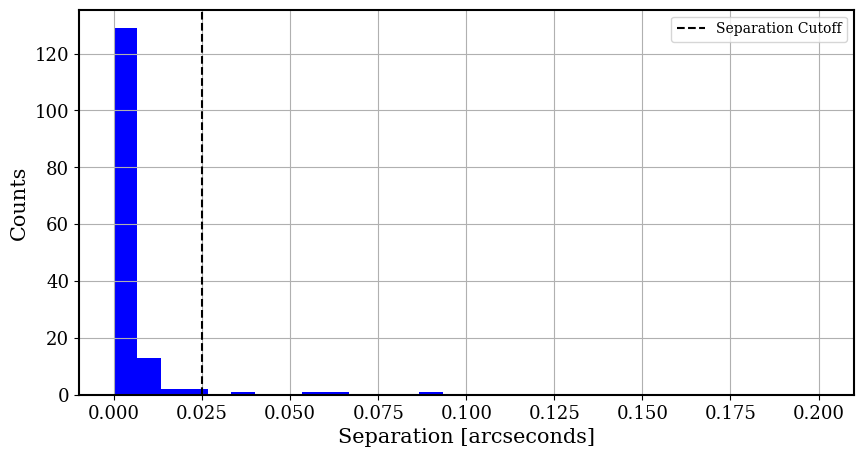

In [19]:
fig, ax = plt.subplots(figsize = (10, 5))
full_matched_LRD_sample.Separation.hist(bins = 30, range = (0, 0.2), ax = ax, color = 'blue')
ax.axvline(0.025, color = 'black', linestyle = '--', label = 'Separation Cutoff')
ax.set_xlabel('Separation [arcseconds]', fontsize = 15)
ax.set_ylabel('Counts', fontsize = 15)
ax.legend()
plt.show()

In [20]:
#We now apply a separation criteria of 0.025 to get the closest matched sources
close_matched_LRD_sample = full_matched_LRD_sample[full_matched_LRD_sample.Separation.values < 0.025]

In [21]:
#We make the full primer catalog into a DataFrame using only the columns needed for Figure 4
FULL_primer_DF = primer_phot_tab[list(cols_to_use)].to_pandas()

In [22]:
#We append a column of the Primer Index since we will need that for the aperture flux portion of figure 4
FULL_primer_DF['Primer_Index'] = np.arange(0, FULL_primer_DF.shape[0])

In [23]:
#we need to remove the LRD sample from this so we reset the index of the DataFrame to the ID and then we will use the
#Primer IDs to drop those rows giving us a sample of galaxies that are not LRDs
Full_non_LRD_Sample = FULL_primer_DF.set_index('ID').drop(labels = close_matched_LRD_sample.Primer_ID.values)

In [24]:
#Double Checking Matching and Dropping code
print(f'The total number of sources in phot_sample is: {len(primer_phot_tab)}')
print(f'The total number of sources in LRD sample is: {close_matched_LRD_sample.shape[0]}')
print(f'The total number of sources in Non-LRD sample is: {Full_non_LRD_Sample.shape[0]}')
print(f'Final Check summing LRD and Non-LRD sample: {close_matched_LRD_sample.shape[0] + Full_non_LRD_Sample.shape[0]}')

The total number of sources in phot_sample is: 116632
The total number of sources in LRD sample is: 145
The total number of sources in Non-LRD sample is: 116487
Final Check summing LRD and Non-LRD sample: 116632


# Converting Flux to Magnitudes

In [25]:
def convert_flux_to_magnitude(flux):
    '''
    This function will convert flux to magnitude. We assume the flux is in nanoJansky

    Mag = -2.5log10(flux) + 31.4
    '''

    return -2.5*np.log10(flux) + 31.4

In [26]:
#looping over all the fluxes and converting them to magnitudes then appending them as new columns in the DataFrame
for f in flux_cols_for_plots:
    filt = f.split('_')[-1]
    close_matched_LRD_sample[f'MAG_{filt}'] = close_matched_LRD_sample[f].apply(convert_flux_to_magnitude)

/var/folders/t2/6968g8md2c9g1mm1h0p9nxl588s4s1/T/ipykernel_98388/284130016.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_matched_LRD_sample[f'MAG_{filt}'] = close_matched_LRD_sample[f].apply(convert_flux_to_magnitude)
/var/folders/t2/6968g8md2c9g1mm1h0p9nxl588s4s1/T/ipykernel_98388/284130016.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_matched_LRD_sample[f'MAG_{filt}'] = close_matched_LRD_sample[f].apply(convert_flux_to_magnitude)
/var/folders/t2/6968g8md2c9g1mm1h0p9nxl588s4s1/T/ipy

In [27]:
#looping over all the fluxes in the non LRD sample
#and converting them to magnitudes then appending them as new columns in the DataFrame
for f in flux_cols_for_plots:
    filt = f.split('_')[-1]
    Full_non_LRD_Sample[f'MAG_{filt}'] = Full_non_LRD_Sample[f].apply(convert_flux_to_magnitude)

In [28]:
def snr_mask(DF, sn_threshold = 5):

    '''
    Function to compute the SNR of all the filters needed in Figure 4 and returning a SNR mask
    '''
    #computing SNR ratio of all the filters to select good quality sources
    sn115 = DF['FLUX_F115W']/ DF['FLUXERR_F115W'] 
    sn200 = DF['FLUX_F200W']/ DF['FLUXERR_F200W'] 
    sn277 = DF['FLUX_F277W']/ DF['FLUXERR_F277W'] 
    sn356 = DF['FLUX_F356W']/ DF['FLUXERR_F356W'] 
    sn444 = DF['FLUX_F444W']/ DF['FLUXERR_F444W'] 

    
    #making a mask to mask out bad data and keep the good data
    sig = (sn115 > sn_threshold )  & (sn200 > sn_threshold ) & \
                (sn277 > sn_threshold ) & (sn356 > sn_threshold ) & (sn444 > sn_threshold )

    return sig

In [29]:
#Getting SNR masks for each of the catalogs
sig_LRD = snr_mask(close_matched_LRD_sample, sn_threshold = 5)
sig_non_LRD = snr_mask(Full_non_LRD_Sample, sn_threshold = 5)

# Computing Colors

In [30]:
#Computing the magnitude differences needed for the plots for each sample
LRD_mag_diff_277_444w = close_matched_LRD_sample.MAG_F277W.values - close_matched_LRD_sample.MAG_F444W.values
LRD_mag_diff_115_200w = close_matched_LRD_sample.MAG_F115W.values - close_matched_LRD_sample.MAG_F200W.values
LRD_mag_diff_277_356w = close_matched_LRD_sample.MAG_F277W.values - close_matched_LRD_sample.MAG_F356W.values

non_LRD_mag_diff_277_444w = Full_non_LRD_Sample.MAG_F277W.values - Full_non_LRD_Sample.MAG_F444W.values
non_LRD_mag_diff_115_200w = Full_non_LRD_Sample.MAG_F115W.values - Full_non_LRD_Sample.MAG_F200W.values
non_LRD_mag_diff_277_356w = Full_non_LRD_Sample.MAG_F277W.values - Full_non_LRD_Sample.MAG_F356W.values

In [31]:
#Getting the aperture flux info, got this information from the Notebook 2 Example in Section 2 Aperture Fluxes
LRD_f444_02 = primer_F444W_aperture_fluxes[close_matched_LRD_sample.Primer_Index.values,5]
LRD_f444_04 = primer_F444W_aperture_fluxes[close_matched_LRD_sample.Primer_Index.values,8]

non_LRD_f444_02 = primer_F444W_aperture_fluxes[Full_non_LRD_Sample.Primer_Index.values,5]
non_LRD_f444_04 = primer_F444W_aperture_fluxes[Full_non_LRD_Sample.Primer_Index.values,8]

In [32]:
#computing ratio for each of the samples
f444_ratio_LRD = LRD_f444_04 / LRD_f444_02
f444_ratio_non_LRD = non_LRD_f444_04 / non_LRD_f444_02

In [33]:
photz_info_primer = Table.read('primercosmos_photz_quantities_v0.2.fits')

In [34]:
primer_ZA = photz_info_primer['ZA']
primer_ZPEAK = photz_info_primer['ZPEAK']

In [35]:
non_LRD_redshift_ZA = primer_ZA[Full_non_LRD_Sample.Primer_Index.values]
non_LRD_redshift_ZPEAK = primer_ZPEAK[Full_non_LRD_Sample.Primer_Index.values]

# The Money Plot

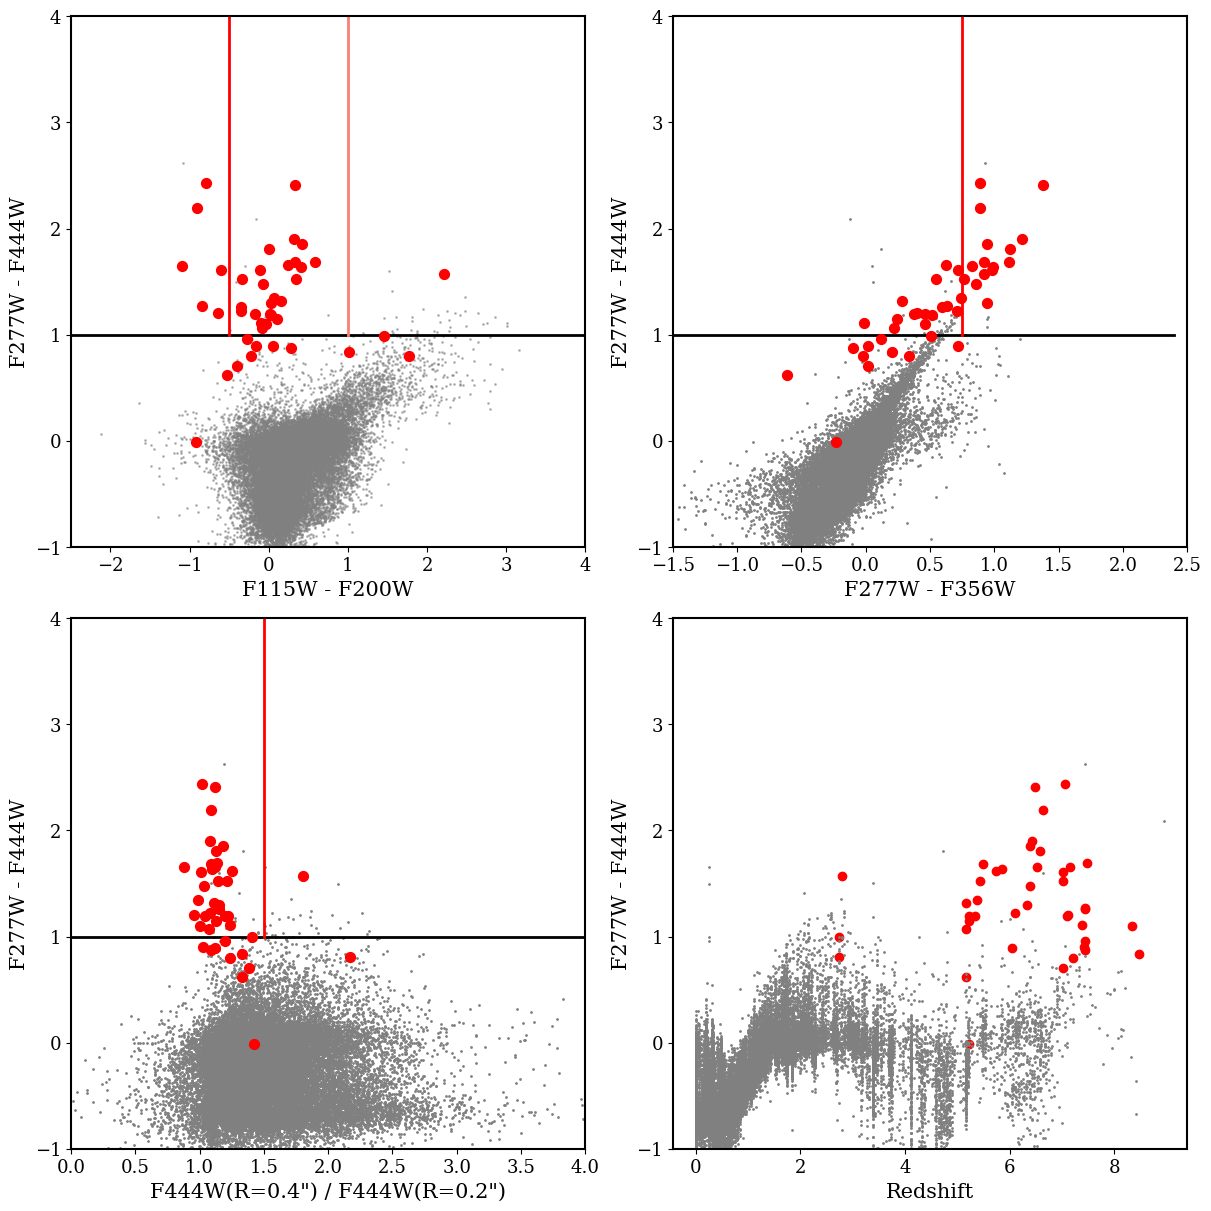

In [36]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12, 12), constrained_layout = True)

ax1.scatter(LRD_mag_diff_115_200w[sig_LRD], LRD_mag_diff_277_444w[sig_LRD], 
            color = 'red', s = 50, zorder = 5)
ax1.scatter(non_LRD_mag_diff_115_200w[sig_non_LRD] , non_LRD_mag_diff_277_444w[sig_non_LRD], 
            color = 'gray', s = 1, alpha = 0.5)

ax1.plot(np.linspace(-2.5,4, 100), np.ones(100), color = 'black', linewidth = 2)
ax1.plot(-0.5*np.ones(100), np.linspace(1, 4, 100), color = 'red', linewidth = 2)
ax1.plot(np.ones(100), np.linspace(1, 4, 100), color = 'salmon', linewidth = 2)

ax1.set_ylim(-1, 4)
ax1.set_xlim(-2.5, 4)
ax1.set_xlabel('F115W - F200W', fontsize = 15)
ax1.set_ylabel('F277W - F444W', fontsize = 15)

ax2.scatter(LRD_mag_diff_277_356w[sig_LRD] , LRD_mag_diff_277_444w[sig_LRD], 
            color = 'red', s = 50, zorder = 5)
ax2.scatter(non_LRD_mag_diff_277_356w[sig_non_LRD] , non_LRD_mag_diff_277_444w[sig_non_LRD], color = 'gray', s = 1)

ax2.plot(np.linspace(-1.5, 2.4, 100), np.ones(100), color = 'black', linewidth = 2)
ax2.plot(0.75*np.ones(100), np.linspace(1, 4, 100), color = 'red', linewidth = 2)



ax2.set_ylim(-1, 4)
ax2.set_xlim(-1.5, 2.5)
ax2.set_xlabel('F277W - F356W', fontsize = 15)
ax2.set_ylabel('F277W - F444W', fontsize = 15)

ax3.scatter(f444_ratio_LRD[sig_LRD], LRD_mag_diff_277_444w[sig_LRD], 
            color = 'red', s = 50, zorder = 5)
ax3.scatter(f444_ratio_non_LRD[sig_non_LRD], non_LRD_mag_diff_277_444w[sig_non_LRD], color = 'gray', s = 1)

ax3.plot(np.linspace(0, 4, 100), np.ones(100), color = 'black', linewidth = 2)
ax3.plot(1.5*np.ones(100), np.linspace(1, 4, 100), color = 'red', linewidth = 2)

ax3.set_ylim(-1, 4)
ax3.set_xlim(0, 4)
ax3.set_xlabel('F444W(R=0.4") / F444W(R=0.2")', fontsize = 15)
ax3.set_ylabel('F277W - F444W', fontsize = 15)

ax4.scatter(close_matched_LRD_sample.za.values[sig_LRD], LRD_mag_diff_277_444w[sig_LRD], color = 'red') 
ax4.scatter(non_LRD_redshift_ZA[sig_non_LRD], non_LRD_mag_diff_277_444w[sig_non_LRD], color = 'gray', s = 1)
ax4.set_ylim(-1, 4)
ax4.set_xlabel('Redshift', fontsize = 15)
ax4.set_ylabel('F277W - F444W', fontsize = 15)
plt.savefig('Oscars_Green_Plot.pdf', dpi = 300)
plt.show()